## Seeding

In [1]:
import torch
import numpy as np
import random
import os
import sys

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

sys.path.append("..")
set_seed(42)

## Load Dataset

In [2]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("jtz18/skin-lesion")

c:\Users\jonta\code\school\t8\DeepLearning\50.039-DL\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jonta\code\school\t8\DeepLearning\50.039-DL\venv\lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for jtz18/skin-lesion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/jtz18/skin-lesion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


## Init Models

In [3]:
from src.segFormer import SegFormer
from src.unet import UNET
from src.unetr import UNETR

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

torch.Size([1, 1, 224, 224])


In [4]:
from src.utils.utils import *
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn

val_transforms = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

_, _, test_loader = get_loaders(
    dataset=dataset,
    batch_size=16,
    train_transform=None,
    val_transform=val_transforms,
    num_workers=0
)

## Evaluation

## Unet Evaluation
Compute the Final Test Dice Score when running best weights on the test set.
**Test Dice Score: 0.8405**

In [5]:
CHECKPOINT_FILENAME = "../checkpoints/unet-checkpoints/checkpoint_7.pth.tar"

model = UNET(
  dropout_rate=0,
  kernel_size=7
).to(device)

checkpoint = torch.load(CHECKPOINT_FILENAME)
model, _, _ = load_checkpoint(checkpoint, model)

=> Loading checkpoint


In [6]:
check_accuracy(test_loader, model, device=device, mode="test", wandb=False)

Got 59978719/65536000 with acc 91.52
Dice score: 0.8404747843742371


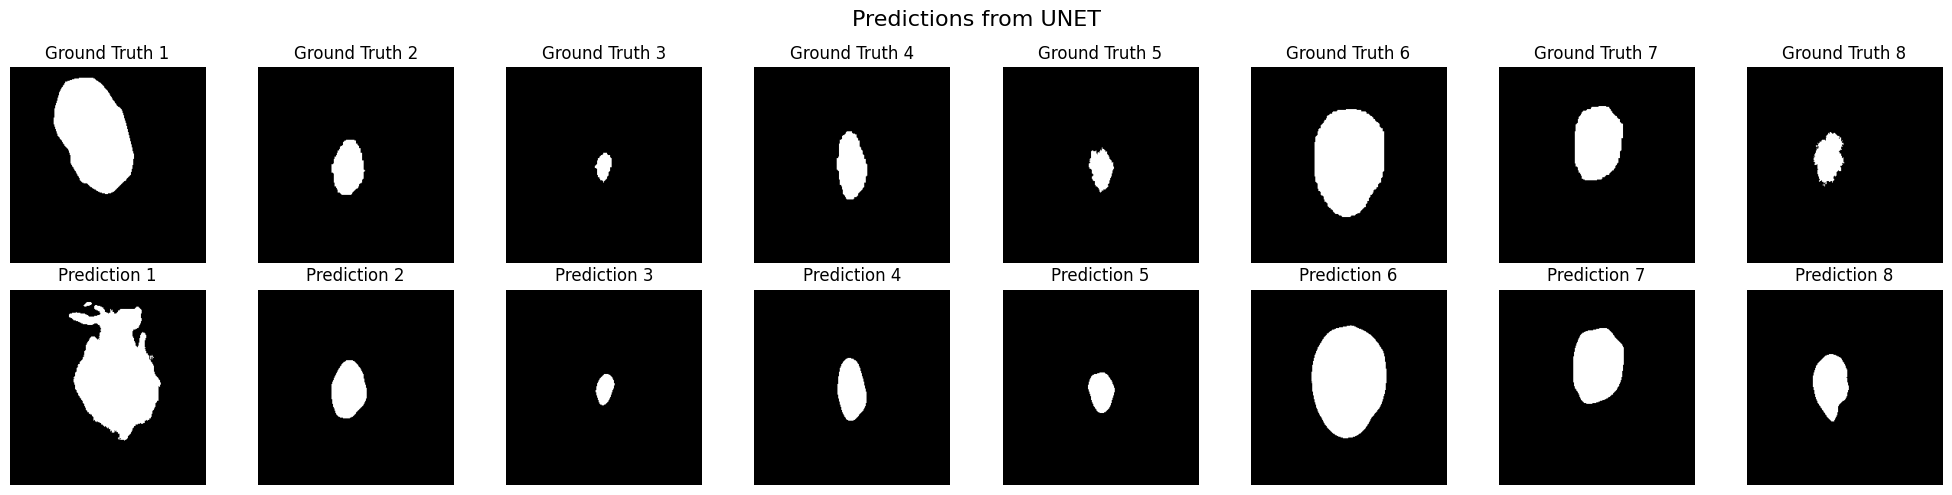

In [7]:
plot_predictions(loader=test_loader, model=model, device=device, no_of_samples=8)

## Unet-r Evaluation
Compute the Final Test Dice Score when running best weights on the test set.
**Test Dice Score: 0.8068**

In [8]:
CHECKPOINT_FILENAME = "../checkpoints/unetr-checkpoints/checkpoint_8.pth.tar"

model = UNETR(
  dropout=0.3,
  embed_dim=256,
  num_heads=8
).to(device)

checkpoint = torch.load(CHECKPOINT_FILENAME)
model, _, _ = load_checkpoint(checkpoint, model)

=> Loading checkpoint


In [9]:
check_accuracy(test_loader, model, device=device, mode="test", wandb=False)

Got 58552488/65536000 with acc 89.34
Dice score: 0.8067812323570251


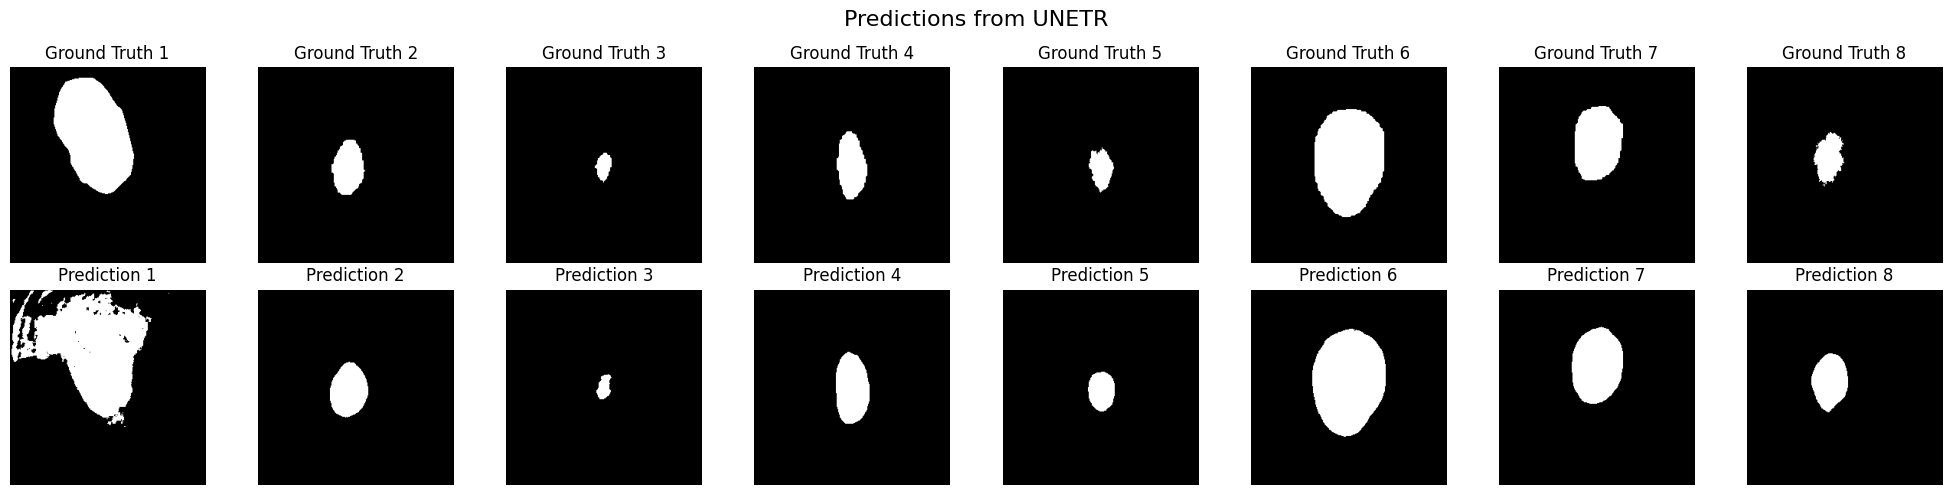

In [10]:
plot_predictions(loader=test_loader, model=model, device=device, no_of_samples=8)

## Segformer Evaluation
Compute the Final Test Dice Score when running best weights on the test set.
**Test Dice Score: 0.8472**

In [11]:
CHECKPOINT_FILENAME = "../checkpoints/segformer-checkpoints/checkpoint_7.pth.tar"

model = SegFormer(
  in_channels=3,
  widths=[64, 128, 256, 512],
  depths=[3, 4, 6, 3],
  all_num_heads=[1, 2, 4, 8],
  patch_sizes=[7, 3, 3, 3],
  overlap_sizes=[4, 2, 2, 2],
  reduction_ratios=[8, 4, 2, 1],
  mlp_expansions=[4, 4, 4, 4],
  decoder_channels=256,
  scale_factors=[8, 4, 2, 1],
  num_classes=1,
  drop_prob=0.3,
).to(device)

checkpoint = torch.load(CHECKPOINT_FILENAME)
model, _, _ = load_checkpoint(checkpoint, model)

=> Loading checkpoint


In [12]:
check_accuracy(test_loader, model, device=device, mode="test", wandb=False)

Got 59957270/65536000 with acc 91.49
Dice score: 0.8472219705581665


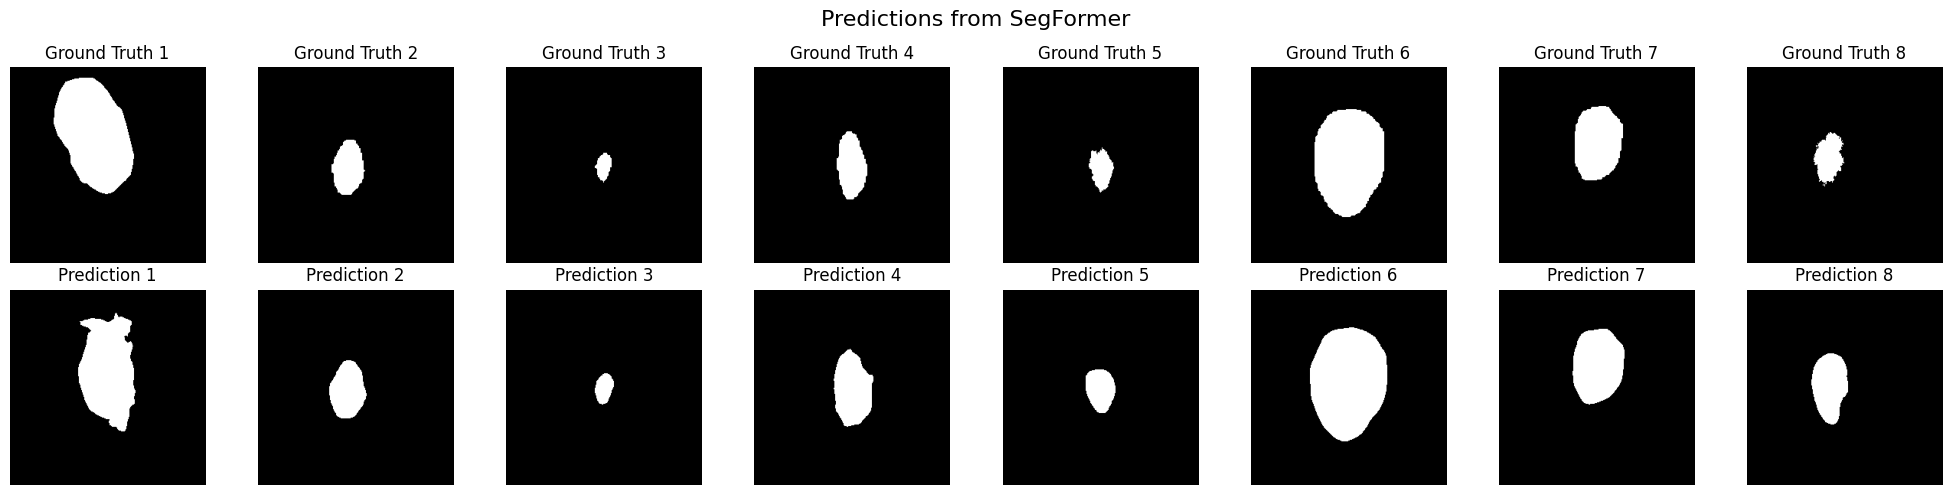

In [13]:
plot_predictions(loader=test_loader, model=model, device=device, no_of_samples=8)

# State Of The Art Evaluation
Compare our models with the state of the art models on the test set.

## TransFuse Evaluation
Compute the Final Test Dice Score when running best weights on the test set.
**Test Dice Score: 0.8595**

In [15]:
from sota.transfuse.TransFuse import TransFuse_S

CHECKPOINT_FILENAME = "../checkpoints/TransFuse-19_best.pth"

model = TransFuse_S().cuda()
model.load_state_dict(torch.load(CHECKPOINT_FILENAME))

c:\Users\jonta\code\school\t8\DeepLearning\50.039-DL\notebooks\..\sota\transfuse\vision_transformer.py:260: UserWarning: Overwriting vit_small_patch16_224 in registry with sota.transfuse.vision_transformer.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
c:\Users\jonta\code\school\t8\DeepLearning\50.039-DL\notebooks\..\sota\transfuse\vision_transformer.py:273: UserWarning: Overwriting vit_base_patch16_224 in registry with sota.transfuse.vision_transformer.vit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_base_patch16_224(pretrained=False, **kwargs):
c:\Users\jonta\code\school\t8\DeepLearning\50.039-DL\notebooks\..\sota\transfuse\vision_transformer.py:285: UserWarning: Overwriting vit_base_patch16_384 in registry with sota.transfuse.vision_transformer.

<All keys matched successfully>

In [16]:
check_accuracy(test_loader, model, device=device, mode="test", wandb=False, img_dims=(192, 256))

Got 44985274/49152000 with acc 91.52
Dice score: 0.859549343585968


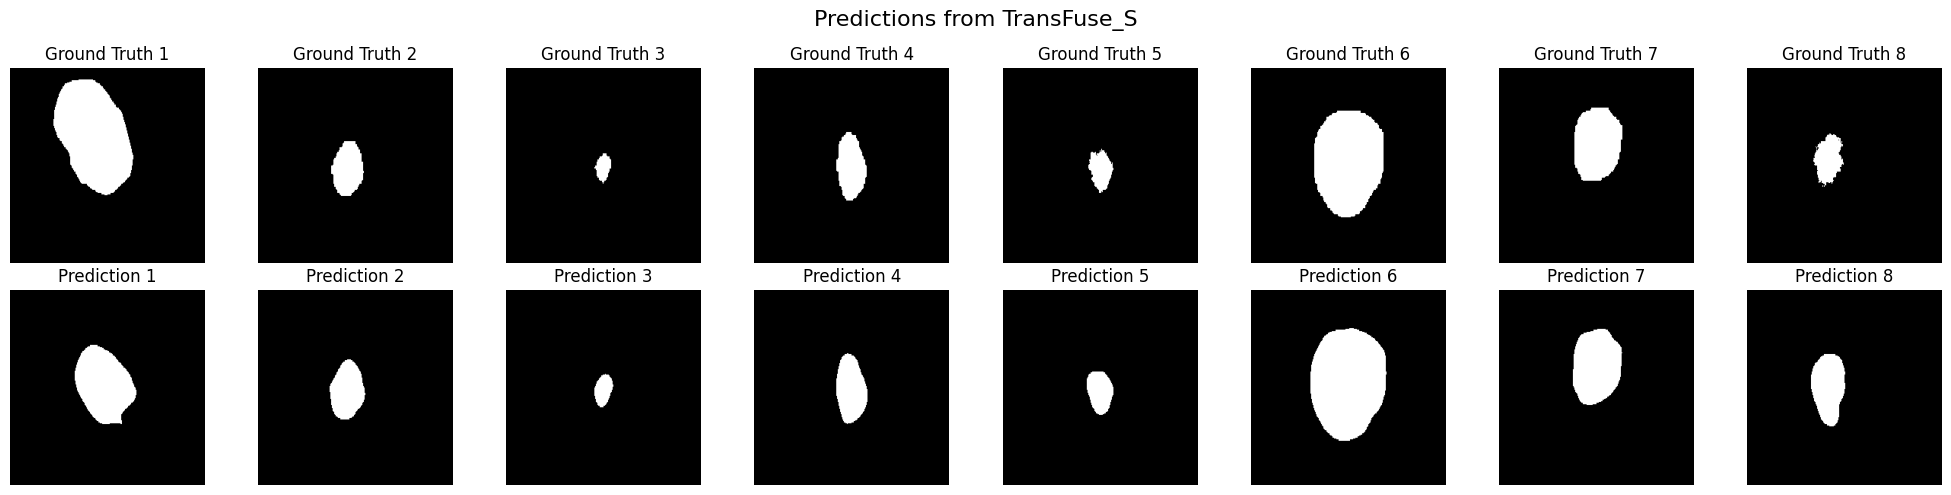

In [17]:
plot_predictions(loader=test_loader, model=model, device=device, no_of_samples=8, img_dims=(192, 256))